In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,normalize
from sklearn.metrics import mean_squared_error
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display
import datetime
from tqdm import tqdm
import random
import time
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [3]:
randomseed= 23
epochs = 1200
valid_every = 2
criterion = nn.MSELoss()

In [4]:
class MCVDDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mcvd_data = pd.read_csv(csv_file)

    def __len__(self):
        return self.mcvd_data.shape[0]

    def __getitem__(self, idx):
        
        data = self.mcvd_data.iloc[idx][6:].values.astype('float32')
        target = (self.mcvd_data.iloc[idx][2])
        sample = {'data': torch.from_numpy(data), 'target': target}

        return sample

In [5]:
def get_test_train_split(df,split=0.25,randomseed=None, silent=False,minimum =3):
    prodids = df['prodid'].unique()
    train_idx = []
    test_idx = []

    for prodid in prodids:
        if (df[df['prodid'] == prodid].shape[0] <minimum):
            if (not silent):
                print("Skipped prodid {} with {} entries".format(prodid,df[df['prodid'] == prodid].shape[0]))
        else:
            #References
            index = df[(df['prodid'] == prodid) & (df['targetval']-df['val'] == 0)].index.values
            train,test = train_test_split(index,test_size=split ,random_state=randomseed)
            [train_idx.append(value) for value in train]
            [test_idx.append(value) for value in test]

            #Targets
            index = df[(df['prodid'] == prodid) & (df['targetval']-df['val'] != 0)].index.values
            train,test = train_test_split(index,test_size=split ,random_state=randomseed)
            [train_idx.append(value) for value in train]
            [test_idx.append(value) for value in test]
            
    return test_idx, train_idx

In [6]:
def get_dev_train_split(df,split=0.5,randomseed=None):
    prodids = df['prodid'].unique()
    valid_idx = []
    test_idx = []
    minimum = 2
    test_next = True

    for prodid in prodids:
        if (df[df['prodid'] == prodid].shape[0] <= minimum):
            if test_next:
                test = df[(df['prodid'] == prodid) & (df['targetval']-df['val'] == 0)].index.values
                [test_idx.append(value) for value in test]
                test_next = False

            else:
                valid = df[(df['prodid'] == prodid) & (df['targetval']-df['val'] == 0)].index.values
                [valid_idx.append(value) for value in valid]
                test_next = True


        else:
                #References
            index = df[(df['prodid'] == prodid) & (df['targetval']-df['val'] == 0)].index.values
            if test_next:
                test,valid = train_test_split(index,test_size=split ,random_state=randomseed)

            else:
                valid,test = train_test_split(index,test_size=split ,random_state=randomseed)

            [valid_idx.append(value) for value in valid]
            [test_idx.append(value) for value in test]

            #Targets
            index = df[(df['prodid'] == prodid) & (df['targetval']-df['val'] != 0)].index.values

            if test_next:
                test,valid = train_test_split(index,test_size=split ,random_state=randomseed)
                test_next = False

            else:
                valid,test = train_test_split(index,test_size=split ,random_state=randomseed)
                test_next = True 

            [valid_idx.append(value) for value in valid]
            [test_idx.append(value) for value in test]
    
    return valid_idx, test_idx

In [7]:
class Net(nn.Module):
    def __init__(self,in_features,out_features):
        super(Net, self).__init__()
        
        self.l_in = nn.Linear(in_features=in_features,
                            out_features=100,
                            bias=True)
        self.l1 = nn.Linear(in_features=100,
                            out_features=50,
                            bias=True)
        
        self.l2 = nn.Linear(in_features=50,
                            out_features=25,
                            bias=True)
        
        self.l3 = nn.Linear(in_features=25,
                            out_features=10,
                            bias=True)
        
        self.l4 = nn.Linear(in_features=10,
                            out_features=1,
                            bias=True)

    def forward(self, x):
        
        x = self.l_in(x)
        x = torch.tanh(x)
        x = self.l1(x)
        x = torch.tanh(x)
        x = self.l2(x)
        x = torch.tanh(x)
        x = self.l3(x)
        x = torch.tanh(x)
        x = self.l4(x)
        
        return x


In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight,gain=nn.init.calculate_gain('tanh'))
        #torch.nn.init.uniform_(m.weight,-0.7,0.7)
        
        m.bias.data.fill_(0.0001)

In [9]:
# pre processing function
def zscale(x, mean, std):
    result = np.subtract(x, mean)
    
    result = np.divide(result, std, out=np.zeros_like(result), where=std!=0)
    
    return result

In [10]:
def norma(x, min, max): 
    result = np.subtract(x, min)
    
    result = np.divide(result, np.subtract(max, min), out=np.zeros_like(result), where=np.subtract(max, min)!=0)
    return result

# Models

## raw input data

In [11]:
dataset = MCVDDataset(csv_file='dataset-goldenref.csv')
#dataset = MCVDDataset(csv_file='dataset.csv')
#dataset = MCVDDataset(csv_file='goldentest.csv')
#dataset = MCVDDataset(csv_file='m21-test-dataset.csv')
dataset.mcvd_data = dataset.mcvd_data.drop('Unnamed: 0',axis=1)
dataset.mcvd_data['starttime'] = pd.to_datetime(dataset.mcvd_data['starttime'])

In [12]:
randomseed = 23
test_idx ,train_idx = get_test_train_split(dataset.mcvd_data,split=0.20,randomseed=randomseed,silent=True)
valid_idx, train_idx = get_test_train_split(dataset.mcvd_data.iloc[train_idx],split=0.20,randomseed=randomseed,silent=True,minimum=1)

#valid_idx, test_idx= get_valid_test_split(dataset.mcvd_data.iloc[remain_idx],split=0.50,randomseed=randomseed)

In [13]:
train_max = np.max(Y_train)
train_min = np.min(Y_train)

NameError: name 'Y_train' is not defined

In [36]:
shape = dataset.__getitem__(0)['data'].shape[0]

X_train = np.empty([0,shape])
Y_train = np.empty([0,1])
for idx in train_idx:
    X_train = np.append(X_train,dataset.__getitem__(idx)['data'].reshape(1,shape),axis=0)
    Y_train = np.append(Y_train,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

#X_train =  zscale(X_train, mean, std)
X_train = torch.tensor(X_train)
    
X_test = np.empty([0,shape])
Y_test = np.empty([0,1])
M_test = np.empty([0,1])
for idx in test_idx:
    X_test = np.append(X_test,dataset.__getitem__(idx)['data'].reshape(1,shape),axis=0)
    Y_test = np.append(Y_test,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)
    M_test =  np.append(M_test,dataset.mcvd_data.iloc[idx,0])
    

#X_test =  zscale(X_test, mean, std)
X_test = torch.tensor(X_test)
    
    
X_valid = np.empty([0,shape])
Y_valid = np.empty([0,1])
for idx in valid_idx:
    X_valid = np.append(X_valid,dataset.__getitem__(idx)['data'].reshape(1,shape),axis=0)
    Y_valid = np.append(Y_valid,dataset.__getitem__(idx)['target'].reshape(1,1),axis=0)

#X_valid =  zscale(X_valid, mean, std)
X_valid = torch.tensor(X_valid)

In [37]:
BATCH_SIZE = 32


trainsampler = SubsetRandomSampler(train_idx)
testsampler = SubsetRandomSampler(test_idx)
validsampler = SubsetRandomSampler(valid_idx)

samplers = {'train': trainsampler,
            'test' : testsampler,
            'valid': validsampler}

trainloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['train'],
                         shuffle=False)
validloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['valid'],
                         shuffle=False)

testloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['test'],
                         shuffle=False)
dataloaders = {'train': trainloader,
               'valid': validloader,
               'test': testloader}

dataset_sizes = {x: len(samplers[x]) for x in ['train', 'valid','test']}

In [38]:
net = Net(in_features=dataset.__getitem__(1)['data'].shape[0],
        out_features=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.apply(init_weights)
net = net.to(device)

C:\Users\bok\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


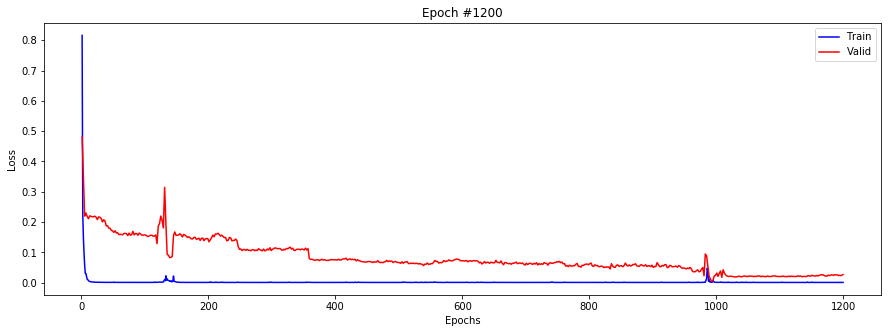

Training loss: 0.00070
Validation loss:0.02660

					Training time 0:05:59.503059


In [39]:
%matplotlib inline
optimizer = optim.Adam(net.parameters())


normin_losses_train = pd.DataFrame(columns=['Epoch','Loss'])
normin_losses_valid = pd.DataFrame(columns=['Epoch','Loss'])

now = datetime.datetime.now()

print("Using device:", device)

for epoch in range(epochs):
    batch_loss = []
   
    net.train()
    for batch in dataloaders['train']:
        inputs = batch['data']
        #inputs = torch.tensor(zscale(inputs.cpu(), mean, std))
        labels = batch['target']
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # make prediction, and do loss / backporopgation
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())             
        
       
    normin_losses_train.loc[epoch] = [epoch+1,np.mean(batch_loss)]
    
    if epoch%valid_every == 0 or epoch == max(range(epochs)):
        batch_loss = []
        normin_predictions = []
        net.eval()
        for batch in dataloaders['valid']:
            inputs = batch['data']
            #inputs = torch.tensor(zscale(inputs.cpu(), mean, std))
            labels = batch['target']
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float) 
            
            # Make prediction
            output = net(inputs)
            loss = criterion(output,labels)
            batch_loss.append(loss.item())
            
            normin_predictions.append((output,labels))
            
            
        
        normin_losses_valid.loc[epoch] = [epoch+1,np.mean(batch_loss)]
    
    
    #################### plotting ###############################
    # Plot the loss every epoch
    pl.figure(figsize=(15,5))
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.title('Epoch #{}'.format(epoch))
    pl.plot(normin_losses_train['Epoch'],normin_losses_train['Loss'], '-b', label='Train')
    pl.plot(normin_losses_valid['Epoch'],normin_losses_valid['Loss'], '-r', label='Valid')
    pl.legend()
    pl.show()
    

    
    print('Training loss: {:.5f}'.format(normin_losses_train['Loss'].iloc[-1]))
    print('Validation loss:{:.5f}'.format(normin_losses_valid['Loss'].iloc[-1]))
    display.clear_output(wait=True)
    #############################################################

#################### plotting ###############################     
# Final plot    
pl.figure(figsize=(15,5))
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.title('Epoch #{}'.format(epoch+1))
pl.plot(normin_losses_train['Epoch'],normin_losses_train['Loss'], '-b', label='Train')
pl.plot(normin_losses_valid['Epoch'],normin_losses_valid['Loss'], '-r', label='Valid')
pl.legend()
pl.show()


print('Training loss: {:.5f}'.format(normin_losses_train['Loss'].iloc[-1]))
print('Validation loss:{:.5f}'.format(normin_losses_valid['Loss'].iloc[-1]))

end = datetime.datetime.now()

print("\n\t\t\t\t\tTraining time {}".format(end-now))
#############################################################

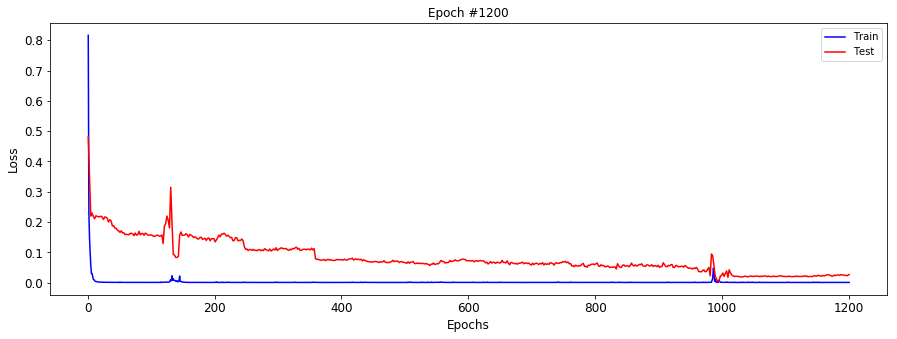


					Training time 0:08:50.009859


In [40]:
pl.figure(figsize=(15,5))
pl.xlabel('Epochs',size='large')
pl.ylabel('Loss',size='large')
pl.title('Epoch #{}'.format(epoch+1))
pl.plot(normin_losses_train['Epoch'],normin_losses_train['Loss'], '-b', label='Train')
pl.plot(normin_losses_valid['Epoch'],normin_losses_valid['Loss'], '-r', label='Test')
pl.legend()
plt.xticks(size = 'large')
plt.yticks(size = 'large')
pl.show()



end = datetime.datetime.now()

print("\n\t\t\t\t\tTraining time {}".format(end-now))

In [413]:
net.eval()

Net(
  (l_in): Linear(in_features=341, out_features=100, bias=True)
  (l1): Linear(in_features=100, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=25, bias=True)
  (l3): Linear(in_features=25, out_features=10, bias=True)
  (l4): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
print('MSE_train: {}'.format(mean_squared_error(Y_train,net(X_train.to(device,dtype=torch.float)).cpu().detach().numpy().reshape(-1))))

print('MSE_valid: {}'.format(mean_squared_error(Y_valid,net(X_valid.to(device,dtype=torch.float)).cpu().detach().numpy().reshape(-1))))
print('MSE_test: {}'.format(mean_squared_error(Y_test,net(X_test.to(device,dtype=torch.float)).cpu().detach().numpy().reshape(-1))))

MSE_train: 0.0007256640793423507
MSE_valid: 0.02580882321820868
MSE_test: 0.010685157863602955


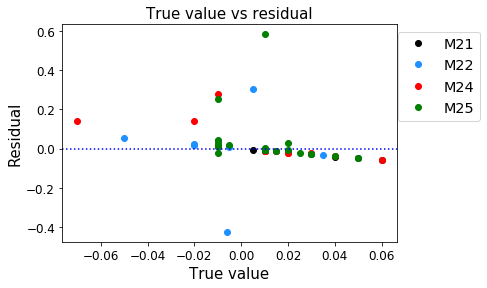

In [44]:
from matplotlib.lines import Line2D
Title = "True value vs residual"
x_label ="True value"
y_label = "Residual"
savename = "D-ANN-raw"

custom_lines = [Line2D([0], [0], color='black',marker='o',linestyle='none'),
                Line2D([0], [0], color='dodgerblue',marker='o',linestyle='none'),
                Line2D([0], [0], color='red',marker='o',linestyle='none'),
               Line2D([0], [0], color='green',marker='o',linestyle='none')]

color_map = {'m21' : 'black','m22': 'dodgerblue','m24': 'red','m25':'green'}
preds = net(X_test.to(device,dtype=torch.float)).cpu().detach().numpy().reshape(-1)


for i,m in enumerate(M_test):
    color = color_map[m]
    plt.plot(Y_test[i],preds[i]-Y_test[i],marker='o', color=color,linestyle='none')
    
    
    
plt.axhline(y=0.0, color='blue', linestyle=':')      
ax = plt.gca()
ax.legend(custom_lines, ['M21', 'M22', 'M24','M25'],bbox_to_anchor=(1.27, 1),fontsize='x-large')
ax.set_xlabel(x_label,size=15)
ax.set_ylabel(y_label,size=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title(Title,size=15)
fig = ax.get_figure()
plt.show()
fig.savefig("{}.pdf".format(savename), bbox_inches='tight')#

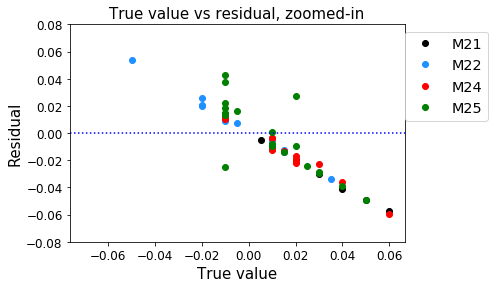

In [45]:
from matplotlib.lines import Line2D
Title = "True value vs residual, zoomed-in"
x_label ="True value"
y_label = "Residual"
savename = "D-ANN-raw-zoom"

custom_lines = [Line2D([0], [0], color='black',marker='o',linestyle='none'),
                Line2D([0], [0], color='dodgerblue',marker='o',linestyle='none'),
                Line2D([0], [0], color='red',marker='o',linestyle='none'),
               Line2D([0], [0], color='green',marker='o',linestyle='none')]

color_map = {'m21' : 'black','m22': 'dodgerblue','m24': 'red','m25':'green'}
preds = net(X_test.to(device,dtype=torch.float)).cpu().detach().numpy().reshape(-1)


for i,m in enumerate(M_test):
    color = color_map[m]
    plt.plot(Y_test[i],preds[i]-Y_test[i],marker='o', color=color,linestyle='none')
    
    
    
plt.axhline(y=0.0, color='blue', linestyle=':')      
ax = plt.gca()
ax.legend(custom_lines, ['M21', 'M22', 'M24','M25'],bbox_to_anchor=(1.27, 1),fontsize='x-large')
ax.set_xlabel(x_label,size=15)
ax.set_ylabel(y_label,size=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title(Title,size=15)
ax.set_ylim(-0.08,0.08)
fig = ax.get_figure()
plt.show()
fig.savefig("{}.pdf".format(savename), bbox_inches='tight')#

In [ ]:
S